In [1]:
%load_ext autoreload

In [2]:
import pandas as pd
import numpy as np
import os
import feather
import matplotlib.pyplot as plt
from itertools import combinations

In [3]:
import sys
if "/proj/yunligrp/users/minzhi/custom_lib" not in sys.path:
    sys.path.insert(0, "/proj/yunligrp/users/minzhi/custom_lib")

In [4]:
from function_process_data_eqtl import *
from function_asso import *
from function_mesa_cca import *
%autoreload 2

### Loading Freeze8 Kinship Matrix for Later Usage

In [5]:
predata_dir = os.path.join("..", "prepro_data", "kinship")
freeze8_kinship_filename = "freeze8_kinship.feather"
freeze8_kinship_dir_filename = os.path.join(predata_dir, freeze8_kinship_filename)
%time freeze8_kinship_df = pd.read_feather(freeze8_kinship_dir_filename, use_threads = True)
freeze8_sample_list = list(freeze8_kinship_df)
freeze8_sample_df = pd.DataFrame(data=freeze8_sample_list, columns=["NWDID"])
freeze8_kinship_df_ID = pd.concat(objs=[freeze8_sample_df, freeze8_kinship_df], axis=1)

CPU times: user 1min 30s, sys: 5min 14s, total: 6min 44s
Wall time: 10min 38s


## Scan All Cohorts

In [18]:
def save_common_df(common_0, common_1, common_col, save_dir, file_type):
    common_df_list = [common_0, common_1]
    common_df = merge_df_list(common_df_list, common_col, merge_method='first')
    common_df_filename = "common_%s.tsv"%file_type
    common_df_dir_filename = os.path.join(save_dir, common_df_filename)
    common_df.to_csv(common_df_dir_filename, sep="\t", index=False)

In [19]:
def common_snp_pc_cn_pheno_kinship(cohort, freeze_ver, pc_num, common_col, snp_list, kinship_df_ID, cn_var = "cn", pheno_filename = None):
    if pheno_filename == None:
        pheno_filename = "pheno_%s.tsv"%cohort
    save_dir = os.path.join("..", "cohort", cohort, "ready_data")
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir, exist_ok = True) 
    snp_dir_filename_list = [os.path.join("..", "prepro_data", "snp", "%s_%s_hetero.tsv"%(freeze_ver, snp_i)) for snp_i in snp_list]
    pc_dir_filename = os.path.join("..", "prepro_data", "pc", "%s_pc%d_pcair.tsv"%(freeze_ver, pc_num))
    cn_dir_filename = os.path.join("..", "cohort", cohort, cn_var, "%s_%s.tsv"%(cohort, cn_var))
    pheno_dir_filename = os.path.join("..", "cohort", cohort, "pre_data", pheno_filename)
    kinship_dir_filename = os.path.join("..", "prepro_data", "kinship", "%s_kinship_sample.tsv"%freeze_ver)
    snp_pc_cn_dir_filename_list = snp_dir_filename_list + [pc_dir_filename, cn_dir_filename, pheno_dir_filename, kinship_dir_filename]
    
    snp_pc_cn_df = read2df_list(snp_pc_cn_dir_filename_list)
    common_snp_0 = merge_df_list(snp_pc_cn_df, common_col, merge_method='first', how = 'inner')
    
    common_snp_0_filename = "common_%s.tsv"%snp_list[0]
    common_snp_0_dir_filename = os.path.join(save_dir, common_snp_0_filename)
    common_snp_0.to_csv(common_snp_0_dir_filename, sep="\t", index=False)
    
    sample_df = common_snp_0[["NWDID"]]
    sample_filename = "common_sample.tsv"
    sample_dir_filename = os.path.join(save_dir, sample_filename)
    sample_df.to_csv(sample_dir_filename, sep="\t", index=False)
    
    snp_num = len(snp_list)
    for snp_idx in range(1, snp_num):
        common_0 = snp_pc_cn_df[snp_idx]
        common_1 = common_snp_0
        file_type = snp_list[snp_idx]
        save_common_df(common_0, common_1, common_col, save_dir, file_type)
    
    save_common_df(snp_pc_cn_df[snp_num], common_snp_0, common_col, save_dir, "pc")
    save_common_df(snp_pc_cn_df[snp_num + 1], common_snp_0, common_col, save_dir, cn_var)
    save_common_df(snp_pc_cn_df[snp_num + 2], common_snp_0, common_col, save_dir, "pheno")
    if cn_var == "cn":
        common_del = cn2del(snp_pc_cn_df[snp_num + 1])
        save_common_df(common_del, common_snp_0, common_col, save_dir, "del")
    
    kinship_sample_selected = kinship_select_sample(kinship_df_ID, sample_df)
    print(kinship_sample_selected.shape)
    common_kinship_filename_prefix = "common_kinship"
    save_kinship_simple(save_dir, common_kinship_filename_prefix, kinship_sample_selected, sample_col = True)

In [20]:
def categorize_df(df, cat_col):
    df_raw = df.copy()
    df_raw[cat_col].fillna("Missing Values", inplace = True) 
    category = list(set(df_raw[cat_col].values.tolist()))
    cat_num_list = []
    for cat_i in category:
        tmp_cat_df = df.loc[df_raw[cat_col] == cat_i, :]
        tmp_cat_num = tmp_cat_df.shape[0]
        cat_num_list.append(tmp_cat_num)
    category_summary_tuple = list(zip(category, cat_num_list))
    category_summary_df = pd.DataFrame(category_summary_tuple, columns = [cat_col, "sample_size"])
    category_summary_df.sort_values(axis = 0, by = cat_col, inplace = True)
    return category_summary_df, category

In [21]:
def genxgen(gen_1, gen_2, gen_1_name, gen_2_name, common_col, save_dir):
#     gen_gen = pd.concat(objs=[gen_1, gen_2[[gen_2_name]]], axis=1)
    gen_gen = gen_1.merge(gen_2, on = common_col, how = "inner")
    gen_gen["%s-%s"%(gen_1_name, gen_2_name)] = gen_gen[gen_1_name] * gen_gen[gen_2_name]
    rearrange_list = [list(gen_gen)[0]] + ["%s-%s"%(gen_1_name, gen_2_name), gen_1_name, gen_2_name]
    gen_gen_rearrange = gen_gen.copy()
    gen_gen_rearrange = gen_gen[rearrange_list]
    gen_gen_rearrange_filename = "common_%s-%s.tsv"%(gen_1_name, gen_2_name)
    gen_gen_rearrange_dir_filename = os.path.join(save_dir, gen_gen_rearrange_filename)
    gen_gen_rearrange.to_csv(gen_gen_rearrange_dir_filename, sep = "\t", header = True, index = False)
    return gen_gen_rearrange

In [22]:
def table1(cohort, cn_var):
    cn_orig_filename = "common_%s.tsv"%cn_var
    cn_orig_dir = os.path.join("..", "cohort", cohort, "ready_data")
    cn_orig_dir_filename = os.path.join(cn_orig_dir, cn_orig_filename)
    cn_orig_df = pd.read_csv(cn_orig_dir_filename, sep="\t")
    if cn_var == "cn":
        cn_binary_df_full = cn2binary_df(cn_orig_df)
        cn_binary_df = cn_binary_df_full[["NWDID", "cn0", "cn1", "cn3", "cn4"]]
        cn_type_list = ["cn0", "cn1", "cn3"]
        for cn_type in cn_type_list:
            cn_binary_df_move = move_cn(cn_binary_df, cn_type)
            cn_binary_df_move_filename = "common_cn-binary_%s.tsv"%cn_type
            cn_binary_df_move_dir_filename = os.path.join(cn_orig_dir, cn_binary_df_move_filename)
            cn_binary_df_move.to_csv(cn_binary_df_move_dir_filename, sep="\t", index=False)
    # to do: add the case of cn_var == "status"

In [23]:
def table2(cohort, gen_name):
#     Load del
    load_dir = os.path.join("..", "cohort", cohort, "ready_data")
    save_dir = load_dir
    del_cn_filename = "common_del.tsv"
    del_cn_dir_filename = os.path.join(load_dir, del_cn_filename)
    del_cn = pd.read_csv(del_cn_dir_filename, sep="\t", header = 0, index_col = None)
    
#     del x gen
    gen_filename = "common_%s.tsv"%gen_name
    gen_dir_filename = os.path.join(load_dir, gen_filename)
    gen = pd.read_csv(gen_dir_filename, sep="\t")
    common_col = "NWDID"
    del_gen = genxgen(del_cn, gen, "del", gen_name, common_col, save_dir)
    
#     Stratify gen by # del
    del_val_tuple = ([0], [1], [2])
    var_name = "del"
    for del_val_list in del_val_tuple:
        strati_gen(del_gen, del_val_list, var_name, gen_name, save_dir)

In [24]:
def strati_gen(var_gen, var_val_list, var_name, gen_name, save_dir):
    gen_var_val = var_gen.loc[var_gen.loc[:, var_name].isin(var_val_list), ["NWDID", gen_name]]
    var_val_name = "".join(map(str, var_val_list))
    gen_var_val_filename = "common_%s_%s%s.tsv"%(gen_name, var_name, var_val_name)
    gen_var_val_dir_filename = os.path.join(save_dir, gen_var_val_filename)
    gen_var_val.to_csv(gen_var_val_dir_filename, sep = "\t", header = True, index = False)

In [25]:
def table3(cohort, gen_name, table3_del_val_tuple, table3_cn_val_tuple):
#     Load del and cn
    load_dir = os.path.join("..", "cohort", cohort, "ready_data")
    save_dir = load_dir
    del_cn_filename = "common_del.tsv"
    del_cn_dir_filename = os.path.join(load_dir, del_cn_filename)
    del_cn = pd.read_csv(del_cn_dir_filename, sep="\t", header = 0, index_col = None)
    
    cn_filename = "common_cn.tsv"
    cn_dir_filename = os.path.join(load_dir, cn_filename)
    cn = pd.read_csv(cn_dir_filename, sep="\t", header = 0, index_col = None)
    
#     cn x gen, del x gen
    gen_filename = "common_%s.tsv"%gen_name
    gen_dir_filename = os.path.join(load_dir, gen_filename)
    gen = pd.read_csv(gen_dir_filename, sep="\t")
    common_col = "NWDID"
    cn_gen = genxgen(cn, gen, "cn", gen_name, common_col, save_dir)
    del_gen = genxgen(del_cn, gen, "del", gen_name, common_col, save_dir)
    
#     Stratify gen by # del
    var_name = "del"
    for del_val_list in table3_del_val_tuple:
        strati_gen(del_gen, del_val_list, var_name, gen_name, save_dir)
        
#     Stratify gen by # cn
    var_name = "cn"
    for cn_val_list in table3_cn_val_tuple:
        strati_gen(cn_gen, cn_val_list, var_name, gen_name, save_dir)

In [70]:
full_pheno_dir = os.path.join("..", "prepro_data", "phenotype")
full_pheno_filename = "freeze8_anno04_af02_btc01-coh03_ddimer_egfr03_adad01.tsv"
full_pheno_dir_filename = os.path.join(full_pheno_dir, full_pheno_filename)
full_pheno = pd.read_csv(full_pheno_dir_filename, sep = "\t", header = 0, index_col = None)
_, cohort_list = categorize_df(full_pheno, "study")

In [71]:
print(cohort_list)

['FHS', 'COPDGene', 'BioMe', 'ARIC', 'GeneSTAR', 'GenSalt', 'CARDIA', 'HyperGEN', 'DHS', 'HCHS_SOL', 'CHS', 'WHI', 'MESA', 'GENOA', 'JHS']


In [74]:
freeze_ver = "freeze8"
common_col = "NWDID"
cn_var = "cn"
pc_num = 11
snp_list = ["rs334", "rs33930165", "rs11248850"]
pheno_prefix = "freeze8_anno04_af02_btc03-coh03_egfr03-ckd_adad01"
for cohort in cohort_list:
    pheno_filename = "%s_%s.tsv"%(pheno_prefix, cohort)
    common_snp_pc_cn_pheno_kinship(cohort, freeze_ver, pc_num, common_col, snp_list, freeze8_kinship_df_ID, cn_var, pheno_filename)
    print("%s common samples found."%cohort)

(2594, 2595)
FHS common samples found.
(4699, 4700)
COPDGene common samples found.
(8029, 8030)
BioMe common samples found.
(3015, 3016)
ARIC common samples found.
(1266, 1267)
GeneSTAR common samples found.
(1717, 1718)
GenSalt common samples found.
(2596, 2597)
CARDIA common samples found.
(1700, 1701)
HyperGEN common samples found.
(344, 345)
DHS common samples found.
(3382, 3383)
HCHS_SOL common samples found.
(2768, 2769)
CHS common samples found.
(8646, 8647)
WHI common samples found.
(3972, 3973)
MESA common samples found.
(1013, 1014)
GENOA common samples found.
(2933, 2934)
JHS common samples found.


### Preparing Data for Each Table

In [26]:
def load_kinship_simple(load_dir, filename_prefix):
    load_dir_filename_prefix = os.path.join(load_dir, filename_prefix)
    load_dir_filename_tsv = "%s.tsv"%load_dir_filename_prefix
    load_dir_filename_feather = "%s.feather"%load_dir_filename_prefix
    if os.path.exists(load_dir_filename_tsv):
        kinship = pd.read_csv(load_dir_filename_tsv, sep = "\t", header = 0, index_col = None)
    elif os.path.exists(load_dir_filename_feather):
        kinship = pd.read_feather(load_dir_filename_feather, use_threads = True)
    return kinship

def save_kinship_simple(save_dir, filename_prefix, kinship, sample_col = True):
    save_dir_filename_prefix = os.path.join(save_dir, filename_prefix)
    save_dir_filename_tsv = "%s.tsv"%save_dir_filename_prefix
    save_dir_filename_feather = "%s.feather"%save_dir_filename_prefix
    if kinship.shape[0] > 5000:
        if sample_col == False:
            kinship.drop(axis = 1, labels = ["NWDID"], inplace = True)
        feather.write_dataframe(kinship, save_dir_filename_feather)
    elif kinship.shape[0] <= 5000:
        kinship.to_csv(save_dir_filename_tsv, sep = "\t", header = True, index = False)

In [27]:
def prepare_matrix_pheno_adad_in_pheno(cohort, phenotype, pheno_full_df, var_name, var_df, table_name, kinship_df_ID, pc10_df, adad_header):
    if not os.path.exists(os.path.join("..", "cohort", cohort, table_name)):
        os.mkdir(os.path.join("..", "cohort", cohort, table_name))
    if not os.path.exists(os.path.join("..", "cohort", cohort, table_name, var_name)):
        os.mkdir(os.path.join("..", "cohort", cohort, table_name, var_name))
        
    save_dir = os.path.join("..", "cohort", cohort, table_name, var_name)
    
    pheno_df_raw = pheno_full_df[["NWDID", "sex", phenotype, "age_at_%s"%phenotype] + adad_header].copy()
    pheno_df_raw.dropna(axis = 1, how = "all", inplace = True)
    adad_header_used = intersection_list(list(pheno_df_raw), adad_header)
    if phenotype not in list(pheno_df_raw):
        return None
    
    pheno_agesex_df = pheno_df_raw.dropna(axis=0)
    common_col = "NWDID"
    pheno_agesex_var_df_list = [pheno_agesex_df, var_df]
    common_pheno_agesex = merge_df_list(pheno_agesex_var_df_list, common_col, merge_method='first')
    common_var = merge_df_list(pheno_agesex_var_df_list, common_col, merge_method='second')
    sample_df = common_pheno_agesex[["NWDID"]].copy()
    
    common_pheno = common_pheno_agesex[["NWDID", phenotype]].copy()
    common_pheno_filename = "common_pheno_%s_%s_%s.tsv"%(table_name, var_name, phenotype)
    common_pheno_dir_filename = os.path.join(save_dir, common_pheno_filename)
    common_pheno.to_csv(common_pheno_dir_filename, sep="\t", index=False)
    
    common_var_filename = "common_var_%s_%s_%s.tsv"%(table_name, var_name, phenotype)
    common_var_dir_filename = os.path.join(save_dir, common_var_filename)
    common_var.to_csv(common_var_dir_filename, sep="\t", index=False)

    common_kinship = kinship_select_sample(kinship_df_ID, sample_df)
    common_kinship_filename_prefix = "common_kinship_%s_%s_%s"%(table_name, var_name, phenotype)
    save_kinship_simple(save_dir, common_kinship_filename_prefix, common_kinship, sample_col = False)

    common_age_sex = common_pheno_agesex[["NWDID", "age_at_%s"%phenotype, "sex"] + adad_header_used].copy()
    common_age_sex_filename = "common_age-sex_%s_%s_%s.tsv"%(table_name, var_name, phenotype)
    common_age_sex_dir_filename = os.path.join(save_dir, common_age_sex_filename)
    common_age_sex.to_csv(common_age_sex_dir_filename, sep="\t", index=False)
    
    common_pc10 = merge_df_list([pc10_df, sample_df], common_col, merge_method='first')
    common_pc10_filename = "common_pc10_%s_%s_%s.tsv"%(table_name, var_name, phenotype)
    common_pc10_dir_filename = os.path.join(save_dir, common_pc10_filename)
    common_pc10.to_csv(common_pc10_dir_filename, sep="\t", index=False)

In [28]:
def wrap_prepare_matrix_pheno_adad_in_pheno(phenotype_list, table_dict, load_dir, adad_dict):
    for table_name in table_dict:
        pheno_full_filename = "common_pheno.tsv"
        pheno_full_dir_filename = os.path.join(load_dir, pheno_full_filename)
        pheno_full_df = pd.read_csv(pheno_full_dir_filename, sep="\t")
        if bool(adad_dict):
            pheno_full_df_raw = pheno_full_df.copy()
            del pheno_full_df
            pheno_full_df, adad_header = adad_header_conversion(pheno_full_df_raw, adad_dict)
            pheno_dummy_adad_filename = "common_pheno_adad_dummy.tsv"
            pheno_dummy_adad_dir_filename = os.path.join(load_dir, pheno_dummy_adad_filename)
            pheno_full_df.to_csv(pheno_dummy_adad_dir_filename, sep = "\t", header = True, index = False)
        else:
            adad_header = []
        
        kinship_filename_prefix = "common_kinship"
        kinship_df_ID = load_kinship_simple(load_dir, kinship_filename_prefix)

        pc_filename = "common_pc.tsv"
        pc_dir_filename = os.path.join(load_dir, pc_filename)
        pc_df = pd.read_csv(pc_dir_filename, sep="\t")
        
        var_name_list = table_dict[table_name]
        for var_name in var_name_list:
            var_filename = "common_%s.tsv"%var_name
            var_dir_filename = os.path.join(load_dir, var_filename)
            var_df = pd.read_csv(var_dir_filename, sep="\t")
        
            for phenotype, i in zip(phenotype_list, range(len(phenotype_list))):
                prepare_matrix_pheno_adad_in_pheno(cohort, phenotype, pheno_full_df, var_name, var_df, table_name, kinship_df_ID, pc_df, adad_header)
#                print("%s (%d/%d) completed."%(phenotype, i + 1, len(phenotype_list)))
        print("%s completed."%table_name)

In [29]:
def adad_header_conversion(df_original, adad_dict):
#     adad_quan_list = adad_dict["quan"]
#     adad_cati_list = adad_dict["cati"]
#     df, adad_cati_dummy_list = cati2dummy_df(df_original, adad_cati_list)
#     adad_header = adad_quan_list + adad_cati_dummy_list
    adad_cati_list = adad_dict["cati"]
    df, adad_header = cati2dummy_df(df_original, adad_cati_list)
    return df, adad_header

In [45]:
cohort_list = ['FHS', 'COPDGene', 'BioMe', 'ARIC', 'GeneSTAR', 'GenSalt', 'CARDIA', 'HyperGEN', 'DHS',
               'HCHS_SOL', 'CHS', 'WHI', 'MESA', 'GENOA', 'JHS']
# cohort_list = ['HCHS_SOL']
gen_name_1 = "rs334"
gen_name_2 = "rs33930165"
gen_name_3 = "rs11248850"
table3_del_val_tuple = ([0], [1, 2])
table3_cn_val_tuple = ([2], [3, 4])
cn_var = "cn"

phenotype_list = ["hemoglobin_mcnc_bld_1", "hematocrit_vfr_bld_1", "rbc_ncnc_bld_1", "DDIMER",
                  "mcv_entvol_rbc_1", "mch_entmass_rbc_1", "mchc_mcnc_rbc_1", "rdw_ratio_rbc_1",
                  "neutrophil_ncnc_bld_1", "lymphocyte_ncnc_bld_1", "basophil_ncnc_bld_1",
                  "eosinophil_ncnc_bld_1", "monocyte_ncnc_bld_1", "wbc_ncnc_bld_1", "lnHBA1C", 
                  "pmv_entvol_bld_1", "platelet_ncnc_bld_1", "EGFRCKDEPI", "CKD", "microcytosis", "anemia"]
table_dict = {"table1":["cn-binary_cn0", "cn-binary_cn1", "cn-binary_cn3", "rs334", "rs33930165"],
              "table2":["rs334_del0", "rs334_del1", "rs334_del2", "del-rs334"],
              "table3":["rs11248850", "rs11248850_del0", "rs11248850_del12", "rs11248850_cn2", "rs11248850_cn34", "del-rs11248850"]}
adad_dict = {"quan":["WEIGHT_FINAL_NORM_OVERALL"], "cati":["gengrp6", "CENTER"]}

for cohort in cohort_list:
    table1(cohort, cn_var)
    table2(cohort, gen_name_1)
    table3(cohort, gen_name_3, table3_del_val_tuple, table3_cn_val_tuple)
    load_dir = os.path.join("..", "cohort", cohort, "ready_data")
    wrap_prepare_matrix_pheno_adad_in_pheno(phenotype_list, table_dict, load_dir, adad_dict)
    print("%s completed."%cohort)

table1 completed.
table2 completed.
table3 completed.
FHS completed.
table1 completed.
table2 completed.
table3 completed.
COPDGene completed.
table1 completed.
table2 completed.
table3 completed.
BioMe completed.
table1 completed.
table2 completed.
table3 completed.
ARIC completed.
table1 completed.
table2 completed.
table3 completed.
GeneSTAR completed.
table1 completed.
table2 completed.
table3 completed.
GenSalt completed.
table1 completed.
table2 completed.
table3 completed.
CARDIA completed.
table1 completed.
table2 completed.
table3 completed.
HyperGEN completed.
table1 completed.
table2 completed.
table3 completed.
DHS completed.
table1 completed.
table2 completed.
table3 completed.
HCHS_SOL completed.
table1 completed.
table2 completed.
table3 completed.
CHS completed.
table1 completed.
table2 completed.
table3 completed.
WHI completed.
table1 completed.
table2 completed.
table3 completed.
MESA completed.
table1 completed.
table2 completed.
table3 completed.
GENOA completed.
t

### Apply MESA (from Methylation) Samples to Kinship Matrix

In [23]:
save_dir = "/pine/scr/m/i/minzhi/mesa_multiomics/methylation_normalized"
sample_filename = "TOPMed_MESA.methylomics.samplesheet_with_feno.mixup_fix.only_BIS.pass_QC.txt"
sample_dir_filename = os.path.join(save_dir, sample_filename)
sample_df_raw = pd.read_csv(sample_dir_filename, sep="\t")
print(sample_df_raw.shape)
sample_df = sample_df_raw[["NWDID"]]
kinship_sample_selected = kinship_select_sample(freeze8_kinship_df_ID, sample_df)
print(kinship_sample_selected.shape)

(1890, 21)
(1890, 1891)


In [39]:
sample_df_unique = sample_df.drop_duplicates(subset ="NWDID", keep = "first", inplace = False)
kinship_sample_unique_selected = kinship_select_sample(freeze8_kinship_df_ID, sample_df_unique)
print(kinship_sample_unique_selected.shape)

(936, 937)


In [52]:
unrelated_dir = "/pine/scr/m/i/minzhi/mesa_multiomics/methylation_normalized"
unrelated_filename = "TOPMed_MESA.1331_samples_unrelated.txt"
unrelated_dir_filename = os.path.join(unrelated_dir, unrelated_filename)
unrelated = pd.read_csv(unrelated_dir_filename, sep = "\t", header = None, index_col = None)
unrelated.rename(columns = {0:"NWDID"}, inplace = True)
overlap_unrelated_methy = sample_df_unique.merge(unrelated, on = "NWDID", how = "inner")
print(overlap_unrelated_methy.shape)

(906, 1)


In [42]:
common_kinship_filename = "mesa_methy_kinship_unique.tsv"
common_kinship_dir_filename = os.path.join(save_dir, common_kinship_filename)
kinship_sample_unique_selected.to_csv(common_kinship_dir_filename, sep="\t", index=False)

In [44]:
common_kinship_filename = "mesa_methy_kinship_unique.tsv"
common_kinship_dir_filename = os.path.join(save_dir, common_kinship_filename)
kinship_sample_unique_selected_IDidx = pd.read_csv(common_kinship_dir_filename, sep="\t", index_col=0, header = 0)

In [45]:
def kinship_filtering(kinship_matrix, thres):
	original_list = list(kinship_matrix.columns)
	sample_num = len(original_list)
	correlated_sample_index = []
	uncorrelation_sample_list = []
	for sample_i in range(1, sample_num):
		for ortho_sample_i in range(sample_i):
			if kinship_matrix.iloc[sample_i, ortho_sample_i] > thres:
				correlated_sample_index.append(ortho_sample_i)
	for sample_i in range(sample_num):
		if sample_i not in correlated_sample_index:
			uncorrelation_sample_list.append(original_list[sample_i])
	return uncorrelation_sample_list

In [48]:
thres_list = [1, 0.2, 0.1, 0.05, 0.03125, 0.025, 0.005]
for thres in thres_list:
    uncorrelation_sample_list = kinship_filtering(kinship_sample_unique_selected_IDidx, thres)
    print(len(uncorrelation_sample_list))

936
925
917
912
910
905
629


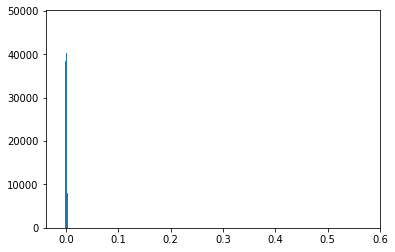

In [34]:
kinship_sample_selected_noID = kinship_sample_selected.drop(axis = 1, labels = "NWDID")
kinship_sample_selected_noID_array = kinship_sample_selected_noID.values
inds = np.tril_indices(kinship_sample_selected_noID_array.shape[0], -1) 
vals = kinship_sample_selected_noID_array[inds]
_ = plt.hist(vals, bins='auto')

In [36]:
thres_list = [0.2, 0.1, 0.05, 0.03125, 0.025, 0.005]
print(vals.shape)
for thres in thres_list:
    tmp_vals = vals[vals <= thres]
    tmp_sample_num = len(tmp_vals)
    print(tmp_sample_num)

(1785105,)
1784083
1784041
1784015
1783993
1783967
1781725


# Association between Blood Cell Trait and SOL

## Preprocess Data

### Phenotype

In [27]:
cohort = "SOL"
save_dir = os.path.join("..", "cohort", cohort, "pre_data")
pheno_filename = "pheno_%s.tsv"%cohort
common_pheno_anno_cn_egfr = pheno_prep(cohort, egfr_df, anno_df, pheno_df)
pheno_wckd_wmicrocytosis_anemia_df = pheno_adding_features_recode_sex(common_pheno_anno_cn_egfr, save_dir, pheno_filename)

#### D-Dimer

In [150]:
ddmier_filename = "TOPMED_HarmonizedPhenotypes_DDIMER_21MAY2019.csv"
ddmier_dir = os.path.join("..", "raw_data", "phenotype")
ddmier_dir_filename = os.path.join(ddmier_dir, ddmier_filename)
ddmier = pd.read_csv(ddmier_dir_filename, sep = ",", header = 0, index_col = None)
ddmier_selected = ddmier[["sample.id", "sample_remove_DDIMER", "DDIMER", "AGE_DDIMER"]] #, "study_race", "sex"
ddmier_selected.rename(columns={"sample.id":"NWDID", "AGE_DDIMER":"age_at_DDIMER"}, inplace=True)
ddmier_selected_filename = "SOL_ddimer.tsv"
ddmier_selected_dir = os.path.join("..", "prepro_data", "phenotype")
ddmier_selected_dir_filename = os.path.join(ddmier_selected_dir, ddmier_selected_filename)
ddmier_selected.to_csv(ddmier_selected_dir_filename, sep = "\t", header = True, index = False)

#### Gengrp6
After testing, to each sample, if s/he has non-NaN SUBJECT_ID and gengrp6 value, then it must have non-NaN CONSENT_text and INTERNAL_USE_ONLY value.

In [151]:
gengrp6_filename = "page-harmonized-phenotypes-pca-freeze2-candidate2-2016-12-14.GWASid_fid_22May2018internalPCs.SOLv2consent.txt"
gengrp6_dir = os.path.join("..", "raw_data", "adjustment", "gengrp6")
gengrp6_dir_filename = os.path.join(gengrp6_dir, gengrp6_filename)
gengrp6 = pd.read_csv(gengrp6_dir_filename, sep = "\t", header = 0, index_col = None)
gengrp6.replace(".", np.nan, inplace=True)
gengrp6_select = gengrp6[["z_sol_id", "analysis_id", "CONSENT_text", "INTERNAL_USE_ONLY",
                          "gengrp6"]].dropna(axis=0, subset=["analysis_id","gengrp6"],how="any")
gengrp6_select.rename(columns = {"analysis_id":"SUBJECT_ID"}, inplace=True)

#### Weight & Center

In [173]:
weight_center_dir = os.path.join("..", "raw_data", "adjustment")
weight_center_filename = "bloodcell_output.csv"
weight_center_dir_filename = os.path.join(weight_center_dir, weight_center_filename)
weight_center = pd.read_csv(weight_center_dir_filename, sep = ",", header = 0, index_col = None)
weight_center_select = weight_center[["ID", "WEIGHT_FINAL_NORM_OVERALL", "CENTER"]].dropna(axis = 0, how = "any")
weight_center_select.rename(columns = {"ID":"z_sol_id"}, inplace = True)

#### Merging Weight & Center Table with Gengrp6 Table

In [153]:
common_col = "z_sol_id"
gengrp6_weight_center_list = [gengrp6_select, weight_center_select]
gengrp6_weight_center = merge_df_list(gengrp6_weight_center_list, common_col, merge_method='merge', how = 'inner')
gengrp6_weight_center.drop(axis = 1, columns = ["z_sol_id"], inplace = True)
gengrp6_weight_center_filename = "SOL_gengrp6_weight_center.tsv"
gengrp6_weight_center_dir = os.path.join("..", "prepro_data", "phenotype")
gengrp6_weight_center_dir_filename = os.path.join(gengrp6_weight_center_dir, gengrp6_weight_center_filename)
gengrp6_weight_center.to_csv(gengrp6_weight_center_dir_filename, sep = "\t", header = True, index = False)

#### Merging Weight, Center, Gengrp6 and D-Dimer into Phenotype Table

In [35]:
gengrp6_weight_center_filename = "SOL_gengrp6_weight_center.tsv"
gengrp6_weight_center_dir = os.path.join("..", "prepro_data", "phenotype")
gengrp6_weight_center_dir_filename = os.path.join(gengrp6_weight_center_dir, gengrp6_weight_center_filename)
gengrp6_weight_center = pd.read_csv(gengrp6_weight_center_dir_filename, sep = "\t", header = 0, index_col = None)
#display(gengrp6_weight_center)

ddimer_filename = "SOL_ddimer.tsv"
ddimer_dir = os.path.join("..", "prepro_data", "phenotype")
ddimer_dir_filename = os.path.join(ddimer_dir, ddimer_filename)
ddimer = pd.read_csv(ddimer_dir_filename, sep = "\t", header = 0, index_col = None)
#display(ddimer)

common_col = "SUBJECT_ID"
pheno_gengrp6_weight_center_list = [pheno_wckd_wmicrocytosis_anemia_df, gengrp6_weight_center]
pheno_gengrp6_weight_center = merge_df_list(pheno_gengrp6_weight_center_list, common_col, merge_method='merge', how = 'outer')

common_col = "NWDID"
pheno_gengrp6_weight_center_ddimer_list = [pheno_gengrp6_weight_center, ddimer]
pheno_gengrp6_weight_center_ddimer = merge_df_list(pheno_gengrp6_weight_center_ddimer_list, common_col, merge_method='merge', how = 'outer')
#display(pheno_gengrp6_weight_center_ddimer)

pheno_gengrp6_weight_center_ddimer.dropna(axis = 0, subset = ["NWDID"], inplace = True)
pheno_gengrp6_weight_center_ddimer = pheno_gengrp6_weight_center_ddimer[pheno_gengrp6_weight_center_ddimer["CONSENT_text"] != "DROP"]
pheno_gengrp6_weight_center_ddimer = pheno_gengrp6_weight_center_ddimer[pheno_gengrp6_weight_center_ddimer["sample_remove_DDIMER"] != 1]

add_adj_dict = {"quant":["WEIGHT_FINAL_NORM_OVERALL"],"cati":["gengrp6", "CENTER"]}
pheno_gengrp6_weight_center_ddimer_dummy_adj, add_adj_list = cati2dummy_df(pheno_gengrp6_weight_center_ddimer, add_adj_dict)



In [ ]:
save_dir = os.path.join("..", "cohort", cohort, "pre_data")
pheno_filename = "pheno_%s_20190904.tsv"%cohort
pheno_dir_filename = os.path.join(save_dir, pheno_filename)
pheno_gengrp6_weight_center_ddimer.to_csv(pheno_dir_filename, sep = "\t", header = True, index = False)

In [42]:
cohort = "SOL"
cn_filename = "%s_cn.tsv"%cohort
cn_dir = os.path.join("..", "cohort", cohort, "cn")
cn_dir_filename = os.path.join(cn_dir, cn_filename)
cn_df = pd.read_csv(cn_dir_filename, sep = "\t", header = 0, index_col = None)

In [53]:
ddmier_filename = "TOPMED_HarmonizedPhenotypes_DDIMER_21MAY2019.csv"
ddmier_dir = os.path.join("..", "raw_data", "phenotype")
ddmier_dir_filename = os.path.join(ddmier_dir, ddmier_filename)
ddmier = pd.read_csv(ddmier_dir_filename, sep = ",", header = 0, index_col = None)

In [43]:
common_col = "NWDID"
cn_df_ddimer_list = [cn_df, ddimer]
cn_df_ddimer_inner = merge_df_list(cn_df_ddimer_list, common_col, merge_method='merge', how = 'inner')

In [54]:
a = cn_df.merge(ddmier, left_on="NWDID", right_on="sample.id")
display(a)

,NWDID,CN,sample.id,unique_subject_key,unique_subject_key_f6a,flag_diff_USK_F8_f6a,subject_id,topmed_project,topmed_phase,funding,...,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32,study


In [96]:
print(duplicates_num(pheno_gengrp6_weight_center_ddimer, "NWDID"))

0
